# 编译 MXNet 模型

**原作者**: [Joshua Z. Zhang](https://zhreshold.github.io/), [Kazutaka Morita](https://github.com/kazum)

本文是使用 Relay 部署 mxnet 模型的介绍性教程。

首先需要安装 `mxnet` 模块。

快速的解决方案：

```bash
pip install mxnet --user
```

或者请参考官方的[安装指南](https://mxnet.apache.org/versions/master/install/index.html)。

In [1]:
# 一些标准导入
import mxnet as mx
import tvm
from tvm import relay
import numpy as np

## 从 gluon 模型动物园下载 Resnet18 模型

在本节中，下载预训练好的 imagenet 模型并对图像进行分类。

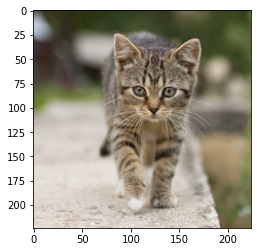

x (1, 3, 224, 224)


In [2]:
from tvm.contrib.download import download_testdata
from PIL import Image
from matplotlib import pyplot as plt


img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_name = "cat.png"
synset_url = "".join(
    [
        "https://gist.githubusercontent.com/zhreshold/",
        "4d0b62f3d01426887599d4f7ede23ee5/raw/",
        "596b27d23537e5a1b5751d2b0481ef172f58b539/",
        "imagenet1000_clsid_to_human.txt",
    ]
)
synset_name = "imagenet1000_clsid_to_human.txt"
img_path = download_testdata(img_url, "cat.png", module="data")
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synset = eval(f.read())
image = Image.open(img_path).resize((224, 224))
plt.imshow(image)
plt.show()


def transform_image(image):
    image = np.array(image) - np.array([123.0, 117.0, 104.0])
    image /= np.array([58.395, 57.12, 57.375])
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :]
    return image


x = transform_image(image)
print("x", x.shape)

##  编译 Graph

想要将 Gluon 模型移植到便携式计算图上，仅仅需要几行代码。

支持 MXNet static graph(symbol) 和 mxnet.gluon 中的 HybridBlock：

In [3]:
from mxnet.gluon.model_zoo.vision import get_model

shape_dict = {"data": x.shape}

block = get_model("resnet18_v1", pretrained=True)
mod, params = relay.frontend.from_mxnet(block, shape_dict)

添加 `softmax` 算子以获取概率：

In [4]:
main_func = mod["main"]
func = relay.Function(main_func.params,
                      relay.nn.softmax(main_func.body),
                      None,
                      main_func.type_params, main_func.attrs)

mod["main"] = func

编译 graph：

In [5]:
target = "cuda"
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)

/media/workspace/anaconda3/envs/mxnetx/lib/python3.10/site-packages/tvm/driver/build_module.py:263: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  warnings.warn(
One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


````{admonition} 已废弃的用法
借助 {class}`~tvm.relay.function.Function`：
```python
func = mod["main"]
func = relay.Function(func.params,
                      relay.nn.softmax(func.body),
                      None,
                      func.type_params, func.attrs)
```

{func}`~tvm.relay.build`：

```python
target = "cuda"
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(func, target, params=params)
```
````

## 在 TVM 上执行可移植 graph

现在，想使用 TVM 重新进行相同的 forward 计算。

In [6]:
from tvm.contrib import graph_executor

# tvm.cuda(0)
dev = tvm.device(dev_type=target,
                 dev_id=0)
dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# set inputs
m.set_input("data", tvm.nd.array(x.astype(dtype)))
# execute
m.run()

In [7]:
# get outputs
tvm_output = m.get_output(0)
top1 = np.argmax(tvm_output.numpy()[0])
print("TVM prediction top-1:", top1, synset[top1])

TVM prediction top-1: 282 tiger cat


## 使用带有预训练权重的 MXNet symbol

MXNet 经常使用 `arg_params` 和 `aux_params` 来分别存储网络参数，这里将展示如何在现有的 API 中使用这些权重。

In [8]:
def block2symbol(block):
    data = mx.sym.Variable("data")
    sym = block(data)
    args = {}
    auxs = {}
    for k, v in block.collect_params().items():
        args[k] = mx.nd.array(v.data().asnumpy())
    return sym, args, auxs


mx_sym, args, auxs = block2symbol(block)
# 通常我们会保存/加载它作为检查点
mx.model.save_checkpoint("resnet18_v1", 0, mx_sym, args, auxs)

在磁盘上生成 `'resnet18_v1-0000.params'` 和 `'resnet18_v1-symbol.json'`。

对于普通的 mxnet 模型，从这里开始：

In [9]:
mx_sym, args, auxs = mx.model.load_checkpoint("resnet18_v1", 0)
# 现在我们使用相同的 API 来获得 Relay 计算图
mod, relay_params = relay.frontend.from_mxnet(mx_sym,
                                              shape_dict,
                                              arg_params=args,
                                              aux_params=auxs)
# 重复相同的步骤来使用 TVM 运行这个模型